In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmqx2


Interatomic Distance: 0.5 VQE Result: -0.9147196848903014 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.03514673882252 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0275114266934384 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0541877549180243 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0470717703154118 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.035344240693446 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -0.9577991905022482 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -0.9678622966984927 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9705662875370151 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9061202002439368 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9233889452643967 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9020333509950316

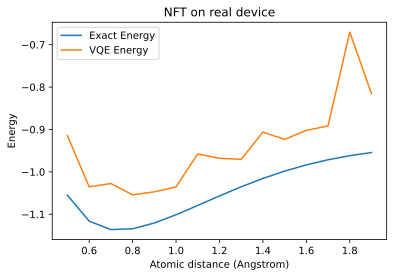

In [2]:
from qiskit.aqua.components.optimizers import NFT
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_ourense")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = NFT(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("NFT on real device")
plt.legend()
plt.savefig("H2_qc_nft.png")
plt.show()

Interatomic Distance: 0.5 VQE Result: -0.9376035563222489 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.02270579110663 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0642944671976533 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0507719540453655 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.052414426879209 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.0378557180442554 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0205653088170594 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0006262008041873 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -1.0032893461075039 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9837848527075774 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9599419891683209 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9412444083876998

Interatomic Distance: 1.1 VQE Result: -1.0275666737142055 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0134921492297235 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9974865754595565 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9858348653051083 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9734699923663678 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9501334868695288 Exact Energy: [-0.98347273]
Interatomic Distance: 1.7 VQE Result: -0.9426685579461129 Exact Energy: [-0.97142669]
Interatomic Distance: 1.8 VQE Result: -0.9289849932721301 Exact Energy: [-0.96181695]
Interatomic Distance: 1.9 VQE Result: -0.9210634690677906 Exact Energy: [-0.95433885]
Interatomic Distance: 0.5 VQE Result: -0.9428235800358122 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0321904677742721 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0510184547888

Interatomic Distance: 1.7 VQE Result: -0.9283065916102211 Exact Energy: [-0.97142669]
Interatomic Distance: 1.8 VQE Result: -0.9364138564627238 Exact Energy: [-0.96181695]
Interatomic Distance: 1.9 VQE Result: -0.9198805501090792 Exact Energy: [-0.95433885]
Interatomic Distance: 0.5 VQE Result: -0.9437212957380632 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0032732941911837 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0477467724663643 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0645797710999547 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0424281586005955 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.010690947841314 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0241063454910204 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0132104571930927 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.97266877987720

Interatomic Distance: 0.8 VQE Result: -1.0688718103526158 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0645446953650874 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.0479536442172936 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.009700467856364 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0110157243574587 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9994693493606002 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9753267102893466 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9663327453040528 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9536997442634572 Exact Energy: [-0.98347273]
Interatomic Distance: 1.7 VQE Result: -0.9365745418398239 Exact Energy: [-0.97142669]
Interatomic Distance: 1.8 VQE Result: -0.9335353150870143 Exact Energy: [-0.96181695]
Interatomic Distance: 1.9 VQE Result: -0.91954855500242

Interatomic Distance: 1.4 VQE Result: -0.9790969325848695 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9646449786675829 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9443984514148145 Exact Energy: [-0.98347273]
Interatomic Distance: 1.7 VQE Result: -0.9429790480231712 Exact Energy: [-0.97142669]
Interatomic Distance: 1.8 VQE Result: -0.9294262696186437 Exact Energy: [-0.96181695]
Interatomic Distance: 1.9 VQE Result: -0.9200778436468371 Exact Energy: [-0.95433885]
Interatomic Distance: 0.5 VQE Result: -0.9333409440294451 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0146560201398291 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0474632356080695 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0568520954187512 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.055670922220708 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.02638757287820

Interatomic Distance: 0.5 VQE Result: -0.9560785428287149 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0292315600733553 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.063067052573464 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.077719991075326 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0627982343204203 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.0442525567959644 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0327858835182053 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -0.9994585664376974 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9998893559351858 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9870696902699991 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.964255536920353 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9544065981612986

Interatomic Distance: 1.1 VQE Result: -1.025245165399454 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.001413441495418 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -1.0024764292217234 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9774391137453344 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9677237163162714 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.9623172800987831 Exact Energy: [-0.98347273]
Interatomic Distance: 1.7 VQE Result: -0.9445894285319882 Exact Energy: [-0.97142669]
Interatomic Distance: 1.8 VQE Result: -0.9314208295271615 Exact Energy: [-0.96181695]
Interatomic Distance: 1.9 VQE Result: -0.9205616695147107 Exact Energy: [-0.95433885]
Interatomic Distance: 0.5 VQE Result: -0.9617917736884969 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.018362698301366 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0434318371103535

Interatomic Distance: 1.7 VQE Result: -0.94219116437169 Exact Energy: [-0.97142669]
Interatomic Distance: 1.8 VQE Result: -0.936852663119979 Exact Energy: [-0.96181695]
Interatomic Distance: 1.9 VQE Result: -0.9278961536323238 Exact Energy: [-0.95433885]
Interatomic Distance: 0.5 VQE Result: -0.9612294648156781 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0265582391591932 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0498161838145244 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0809566242176007 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0569529455931757 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.0412606061605019 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.032522575576166 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0077664414158203 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.98650005117354 Ex

ValueError: x and y must have same first dimension, but have shapes (15,) and (0,)

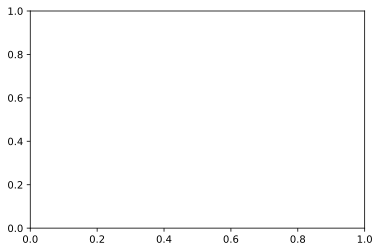

In [10]:
from qiskit.aqua.components.optimizers import COBYLA
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_ourense")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

times = 50
distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=1000)
results = np.zeros([times, len(distances)])
for i in range(times):
    for dist in distances:
        driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
        molecule = driver.run()
        repulsion_energy = molecule.nuclear_repulsion_energy
        num_particles = molecule.num_alpha + molecule.num_beta
        num_spin_orbitals = molecule.num_orbitals * 2
        ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
        qubitOp = ferOp.mapping(map_type='parity')
        qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
        exact_solution = NumPyEigensolver(qubitOp).run()
        exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
        #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
        #print(num_spin_orbitals, num_particles)
        initial_state = HartreeFock(
            num_spin_orbitals,
            num_particles,
            qubit_mapping='parity'
        )
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity'
        )
        vqe = VQE(qubitOp, var_form, optimizer=optimizer)
        ret = vqe.run(quantum_instance)
        vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
        vqe_energies.append(vqe_result)
        print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    results[i, :] = vqe_energies
    exact_energies = []
    vqe_energies = []
    
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("COBYLA on real device")
plt.legend()
plt.savefig("H2_qc_cobyla.png")
plt.show()

In [11]:
results

array([[-0.93760356, -1.02270579, -1.06429447, -1.05077195, -1.05241443,
        -1.03785572, -1.02056531, -1.0006262 , -1.00328935, -0.98378485,
        -0.95994199, -0.94124441, -0.92990816, -0.92984802, -0.92555053],
       [-0.93079821, -1.01298385, -1.04833404, -1.05735594, -1.06341759,
        -1.04960572, -1.01925134, -0.98736603, -1.00045365, -0.98081556,
        -0.97014022, -0.95214592, -0.94354049, -0.92342367, -0.9327701 ],
       [-0.94531331, -1.02169357, -1.04925916, -1.06338326, -1.05541303,
        -1.03677989, -1.02331339, -1.00391464, -0.99723716, -0.97674372,
        -0.95589441, -0.95138176, -0.94216041, -0.93228432, -0.92524353],
       [-0.92067941, -1.03869599, -1.06328501, -1.05883833, -1.05683145,
        -1.03052421, -1.02863467, -1.01882229, -0.99743065, -0.97776574,
        -0.96852802, -0.93356639, -0.94054934, -0.9320069 , -0.92702502],
       [-0.95139266, -1.03044206, -1.0612181 , -1.0626778 , -1.06218838,
        -1.04258233, -1.02805503, -1.01022205, 

In [12]:
np.mean(results, axis=0)

array([-0.9423343 , -1.0216686 , -1.05097006, -1.06277518, -1.05719084,
       -1.04117298, -1.02601262, -1.00821088, -0.99285081, -0.97851465,
       -0.96292795, -0.94844346, -0.93904974, -0.93038997, -0.92437805])

Interatomic Distance: 0.5 VQE Result: -0.8979532204417102 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -0.9799592598065023 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0147290320730349 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0203552001736926 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.033113154462681 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.005601940470408 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -0.9828780056956251 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -0.9610347661239076 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9245900178063577 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9044770349692539 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.8676714711193473 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.845293082152209

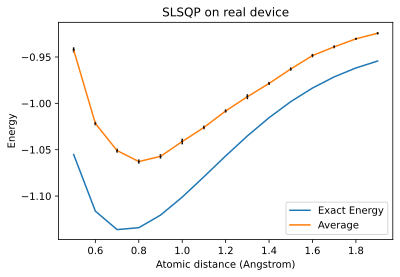

In [24]:
from qiskit.aqua.components.optimizers import SLSQP
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx2")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
plt.plot(distances, exact_energies, label="Exact Energy")
#plt.plot(distances, vqe_energies, label="VQE Energy")
plt.plot(distances, np.mean(results, axis=0), label='Average')
plt.errorbar(distances, np.mean(results, axis=0), yerr = np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0])), fmt='o', markersize=1, ecolor='black', markeredgecolor = "black", color='w')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("SLSQP on real device")
plt.legend()
plt.savefig("H2_qc_slsqp.png")
plt.show()

In [20]:
len(results[0])

15

In [18]:
np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0]))

array([0.00274733, 0.0020754 , 0.00216842, 0.00221553, 0.00235493,
       0.00304867, 0.00195635, 0.00170903, 0.00266685, 0.00166412,
       0.00173932, 0.00184602, 0.00156114, 0.00110301, 0.00114991])

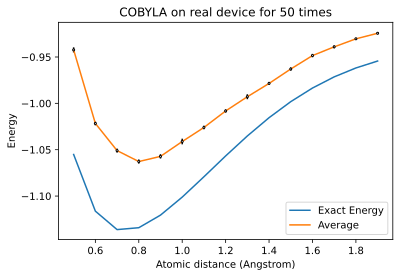

In [27]:
plt.plot(distances, exact_energies, label="Exact Energy")
#plt.plot(distances, vqe_energies, label="VQE Energy")
plt.plot(distances, np.mean(results, axis=0), label='Average')
plt.errorbar(distances, np.mean(results, axis=0), yerr = np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0])), fmt='o', markersize=2, ecolor='black', markeredgecolor = "black", color='w')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("COBYLA on real device for 50 times")
plt.legend()
plt.savefig("H2_qc_cobyla_50times.png")
plt.show()